In [31]:
import os
import json
import requests
import datetime
from bs4 import BeautifulSoup
from openai import AzureOpenAI
from langchain_openai import AzureChatOpenAI
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [32]:
from chat_llms import *
from utils import *

import importlib
import prompts
importlib.reload(prompts)
from revised_prompts import *

In [33]:
llm = creat_llm()
run_id_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [34]:
def refine_slc_prompt(original_prompt, input_dict={}, num_comparison_choices=3):
    # get original output
    slc_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', original_prompt),
            ('human', scenario_library_creation_task_prompt),
        ]
    )
    slc_model = slc_prompt | llm
    scenario_library_output = slc_model.invoke(input_dict)
    scenario_library = scenario_library_output.content
    # critic -> comments
    slc_critic_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_critic_system_prompt),
            ('human', slc_critic_task_prompt),
        ]
    )
    slc_critic = slc_critic_prompt | llm
    slc_critic_output = slc_critic.invoke({'scenario_library': scenario_library})
    slc_comments = slc_critic_output.content
    # refiner -> refined prompt
    slc_refiner_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_refiner_system_prompt),
            ('human', slc_refiner_task_prompt),
        ]
    )
    slc_refiner = slc_refiner_prompt | llm
    refined_prompt_output = slc_refiner.invoke({'original_prompt': original_prompt, 'scenario_library': scenario_library, 'critic_comments': slc_comments})
    refined_prompt = refined_prompt_output.content
    # get refined output
    slc_refined_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', refined_prompt),
            ('human', scenario_library_creation_task_prompt),
        ]
    )
    slc_refined_model = slc_refined_prompt | llm
    refined_scenario_library_output = slc_refined_model.invoke(input_dict)
    refined_scenario_library = refined_scenario_library_output.content
    refined_slc_critic_output = slc_critic.invoke({'scenario_library': refined_scenario_library})
    refined_slc_comments = refined_slc_critic_output.content
    # pairwise comparison
    slc_comparison_prompt = ChatPromptTemplate.from_messages(
        [
            ('system', slc_comparison_system_prompt),
            ('human', slc_comparison_task_prompt),
        ]
    )
    slc_comparison_model = slc_comparison_prompt | llm
    input_dict_for_comparison = {
        'slc_critic_system_prompt': slc_critic_system_prompt,
        'scenario_library_a': scenario_library,
        'scenario_library_b': refined_scenario_library,
    }
    comparison_better_list = []
    comparison_degree_list = []
    comparison_analysis_list = []
    for i in range(num_comparison_choices):
        comparison_analysis = slc_comparison_model.invoke(input_dict_for_comparison)
        comparison_analysis = comparison_analysis.content
        comparison_analysis_list.append(comparison_analysis)
        try:
            comparison_analysis_dict = json.loads(comparison_analysis)
        except:
            print(comparison_analysis)
        comparison_better_list.append(comparison_analysis_dict['better'])
        comparison_degree_list.append(comparison_analysis_dict['degree'])
    overall_better = max(set(comparison_better_list), key=comparison_better_list.count)
    average_degree = sum(comparison_degree_list) / len(comparison_degree_list)
    return {
        'original_prompt': original_prompt,
        'refined_prompt': refined_prompt,
        'overall_better': overall_better,
        'average_degree': average_degree,
        'scenario_library': safe_json_loads(scenario_library),
        'refined_scenario_library': safe_json_loads(refined_scenario_library),
        'critic_comments': safe_json_loads(slc_comments),
        'refined_critic_comments': safe_json_loads(refined_slc_comments),
        'comparison_analysis_list': [safe_json_loads(comparison_analysis) for comparison_analysis in comparison_analysis_list],
    }

In [35]:
user_info = 'Programmer, Junior'

In [36]:
input_dict = {'user_info': user_info}
original_prompt = scenario_library_creation_original_system_prompt

max_refinement_rounds = 10
refinement_results_list = []
average_degree_list = []
overall_better_list = []
# runtime_str = datetime.datetime.now().strftime('%Y%m%d%-H%M%S')
for round_id in range(max_refinement_rounds):
    refinement_results = refine_slc_prompt(original_prompt, input_dict)
    refinement_results_list.append(refinement_results)

    refinement_results_file_path = f'results/slc_refinement_results_{round_id}_{run_id_str}.json'
    save_json(refinement_results_file_path, refinement_results)

    overall_better_list.append(refinement_results['overall_better'])
    average_degree_list.append(refinement_results['average_degree'])

    print(f'Round {round_id}: Prompt {refinement_results["overall_better"]} is better ({refinement_results["average_degree"]})')
    if refinement_results['overall_better'] == 1:
        original_prompt = refinement_results['refined_prompt']

    if round_id >= 3:
        latest_dedup_overall_better_list = list(set(overall_better_list[-3:]))
        if len(latest_dedup_overall_better_list) == 1 and latest_dedup_overall_better_list[0] == 0:
            break
        latest_dedup_average_degree_list = list(set(average_degree_list[-3:]))
        if len(latest_dedup_average_degree_list) == 1 and latest_dedup_average_degree_list[0] <= 0:
            break

KeyError: 'Input to ChatPromptTemplate is missing variables {"\\n    \'scenes\'"}.  Expected: ["\\n    \'scenes\'", \'user_info\'] Received: [\'user_info\']\nNote: if you intended {\n    \'scenes\'} to be part of the string and not a variable, please escape it with double curly braces like: \'{{\n    \'scenes\'}}\'.'

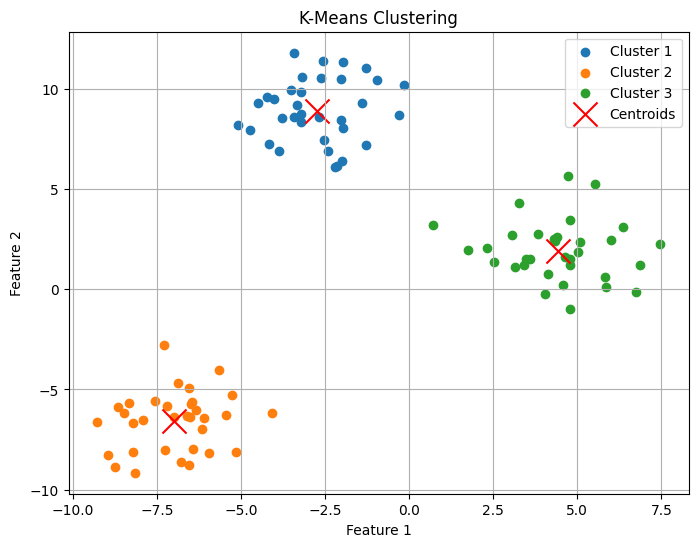

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# 生成二维数据集 (100 个点，分成 3 类)
X, y = make_blobs(n_samples=100, centers=3, random_state=42, cluster_std=1.5)

# 使用 KMeans 进行聚类
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

# 获取聚类结果
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# 绘制结果
plt.figure(figsize=(8, 6))

# 绘制每个簇的点
for i in range(3):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], label=f'Cluster {i + 1}')

# 绘制质心
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='red', marker='x', label='Centroids')

plt.title("K-Means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()
